In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
# CSV dosyasini dogru sinirlayici ile yukleme
df = pd.read_csv('/kaggle/input/erenum/e-ticaret_urun_yorumlari.csv', delimiter=';')

# DataFrame'in ilk birkac satirini goruntuleme
print(df.head())

# Veri On Isleme
X = df['Metin'].values
y = df['Durum'].values

# Hedef degiskeni kodlama
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

# Verileri egitim ve test setlerine ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenlestirme
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq)
X_test_padded = pad_sequences(X_test_seq, maxlen=X_train_padded.shape[1])

# Yapay Sinir Agi Mimarisi Olusturma
embedding_dim = 100  
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_train_padded.shape[1]))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Modeli Derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli Egitme
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

# Modeli degerlendirme
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

                                               Metin  Durum
0                              evet anlatıldığı gibi      1
1  Daha öncede almıştım bu cihazdan ense ve sakal...      1
2  Ürün gayet başarılı sakal kesmede başlık sayıs...      1
3  Daha öncede aynısını almıştım çok güzel ve kal...      1
4  Erkek kuaförüyüm ense ve sıfır sakal traşı içi...      1
Epoch 1/10
380/380 [==============================] - 11s 25ms/step - loss: 0.4997 - accuracy: 0.8008 - val_loss: 0.3346 - val_accuracy: 0.8724
Epoch 2/10
380/380 [==============================] - 8s 22ms/step - loss: 0.2703 - accuracy: 0.8976 - val_loss: 0.3238 - val_accuracy: 0.8837
Epoch 3/10
380/380 [==============================] - 8s 21ms/step - loss: 0.1997 - accuracy: 0.9277 - val_loss: 0.3483 - val_accuracy: 0.8807
Epoch 4/10
380/380 [==============================] - 8s 20ms/step - loss: 0.1412 - accuracy: 0.9497 - val_loss: 0.4207 - val_accuracy: 0.8741
Epoch 5/10
380/380 [==============================] - 8s 22ms/step 

In [3]:
# Modeli Kaydetme
model.save("/kaggle/working/my_model")
# Modeli Yukleme
from keras.models import load_model
loaded_model = load_model("/kaggle/working/my_model")

In [4]:
# New input data
new_text = [
    "fena değilmiş  "
]

# Tokenize and pad new input data
new_sequences = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_sequences, maxlen=X_train_padded.shape[1])

# Make predictions
predictions = model.predict(new_padded)

# The predictions are probabilities for each class
# You can use numpy.argmax to get the index of the class with the highest probability
predicted_class_index = predictions.argmax(axis=-1)[0]

# Decode the index to get the original class label
predicted_class = le.inverse_transform([predicted_class_index])[0]

print(f"The predicted class is: {predicted_class}")

1/1 [==============================] - 0s 137ms/step
The predicted class is: 2


95/95 [==============================] - 1s 6ms/step


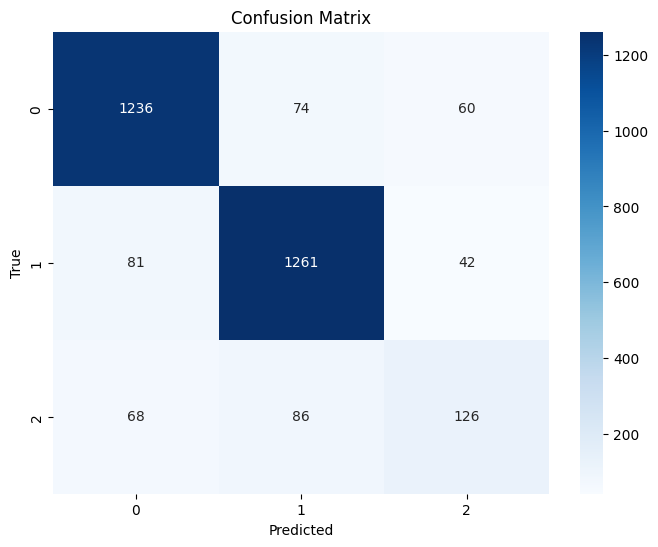

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1370
           1       0.89      0.91      0.90      1384
           2       0.55      0.45      0.50       280

    accuracy                           0.86      3034
   macro avg       0.78      0.75      0.76      3034
weighted avg       0.86      0.86      0.86      3034



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test_padded)

# Convert predictions to class labels
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))


In [8]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
import re

# Metni temizleme ve on isleme fonksiyonu
def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(separator=' ')

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Convert Turkish characters to ASCII
    text = unidecode(text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

# URL'yi belirleyin
url = "https://www.haber7.com/yorum/oku/3373867"

# Web sayfasini cekme 
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

# Yorumlari iceren HTML etiketlerini bulup yerlestirme
comments = soup.find_all('div', class_='content')  

# Yorumlari bir liste icinde saklayip on islem uygulama
comments_list = [preprocess_text(comment.text.strip()) for comment in comments]

# Tokenizer'i kullanarak yorumlari sayilara donusturme ve padding uygulama
X_new_seq = tokenizer.texts_to_sequences(comments_list)
X_new_padded = pad_sequences(X_new_seq, maxlen=X_train_padded.shape[1])

# Modeli kullanarak tahmin yapın
predictions = loaded_model.predict(X_new_padded)

# Tahminleri label'lere cevirme
predicted_labels = le.inverse_transform(predictions.argmax(axis=1))

# Tahmin sonuclarini iceren DataFrame'i olusturma
result_df = pd.DataFrame({'Metin': comments_list, 'Durum': predicted_labels})

# DataFrame'i .csv dosyasina kaydetme
result_df.to_csv('predicted_comments_15.csv', index=False, sep=';')


1/1 [==============================] - 0s 26ms/step


95/95 [==============================] - 0s 2ms/step


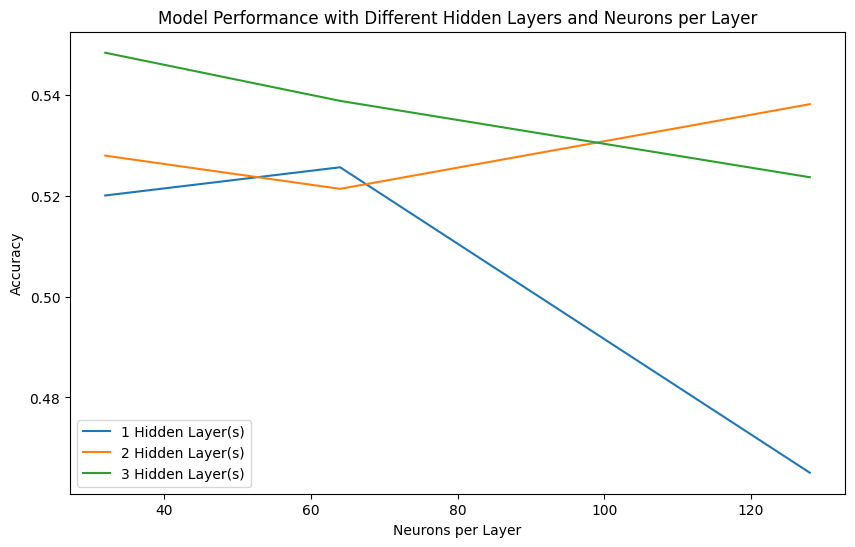

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume you have a function to create and compile a model with given parameters
def create_model(hidden_layers, neurons_per_layer):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim=X_train_padded.shape[1], activation='relu'))

    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))

    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Lists to store results
hidden_layers_list = [1, 2, 3]
neurons_per_layer_list = [32, 64, 128]
accuracy_results = []

# Train and evaluate models with different configurations
for hidden_layers in hidden_layers_list:
    for neurons_per_layer in neurons_per_layer_list:
        model = create_model(hidden_layers, neurons_per_layer)
        model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), verbose=0)
        y_pred = model.predict(X_test_padded)
        y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
        accuracy = accuracy_score(y_true_labels, y_pred_labels)
        accuracy_results.append((hidden_layers, neurons_per_layer, accuracy))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for hidden_layers in hidden_layers_list:
    data = [result[2] for result in accuracy_results if result[0] == hidden_layers]
    ax.plot(neurons_per_layer_list, data, label=f'{hidden_layers} Hidden Layer(s)')

ax.set_xlabel('Neurons per Layer')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Different Hidden Layers and Neurons per Layer')
ax.legend()
plt.show()


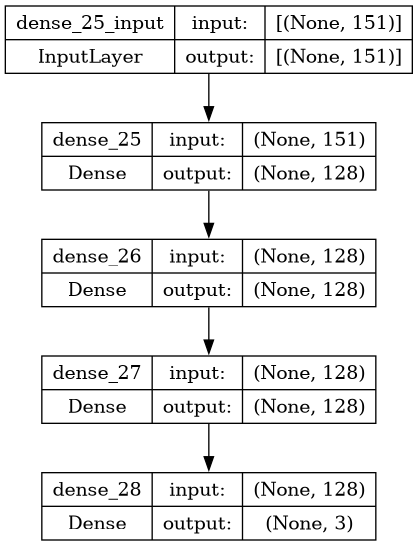

In [10]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot
from IPython.display import Image
Image(filename='model_plot.png')


Epoch 1/10
380/380 [==============================] - 1s 3ms/step - loss: 0.8190 - accuracy: 0.6079 - val_loss: 1.0428 - val_accuracy: 0.5363
Epoch 2/10
380/380 [==============================] - 1s 3ms/step - loss: 0.8187 - accuracy: 0.6046 - val_loss: 1.0494 - val_accuracy: 0.5323
Epoch 3/10
380/380 [==============================] - 1s 3ms/step - loss: 0.7870 - accuracy: 0.6177 - val_loss: 1.0262 - val_accuracy: 0.5452
Epoch 4/10
380/380 [==============================] - 1s 3ms/step - loss: 0.7804 - accuracy: 0.6247 - val_loss: 1.0919 - val_accuracy: 0.5379
Epoch 5/10
380/380 [==============================] - 1s 3ms/step - loss: 0.7800 - accuracy: 0.6217 - val_loss: 1.0636 - val_accuracy: 0.5435
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.7607 - accuracy: 0.6323 - val_loss: 1.1284 - val_accuracy: 0.5435
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.7676 - accuracy: 0.6286 - val_loss: 1.0767 - val_accuracy: 0.5557
Epoch 

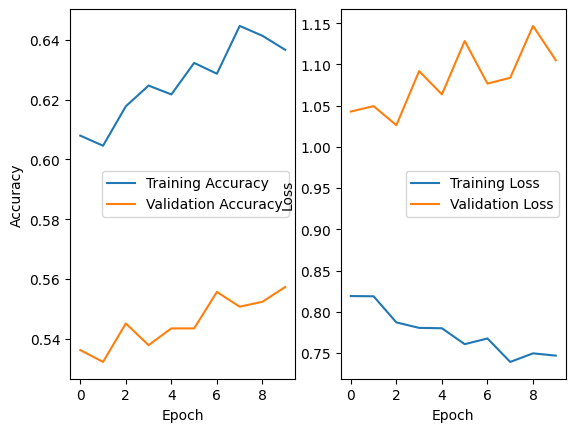

95/95 [==============================] - 0s 2ms/step - loss: 1.1051 - accuracy: 0.5574
Accuracy: 55.74%


In [12]:
import matplotlib.pyplot as plt

# Train your model and collect the training history
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')
